In [ ]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plot

<ipython-input-3-61ef1ed9f933>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread("/content/mario.jpeg")


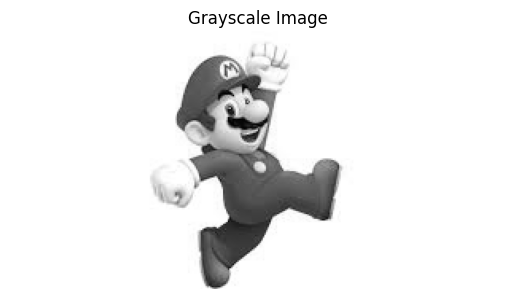

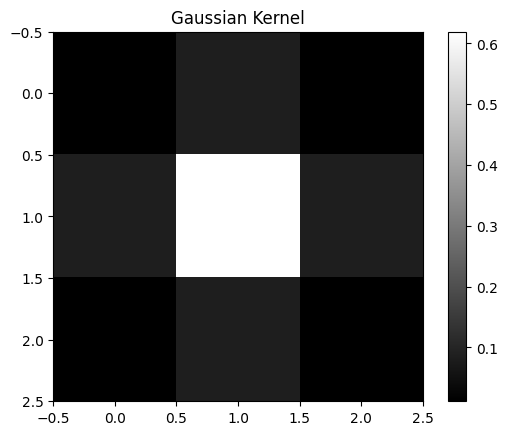

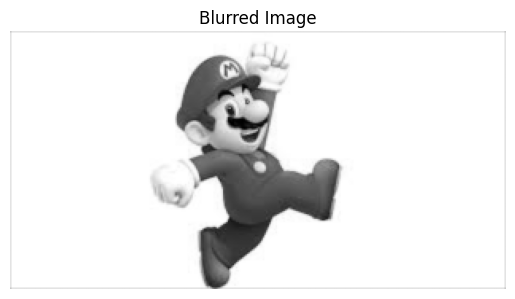

In [ ]:
img = imread("/content/mario.jpeg")

# We use the most common method - NTSC formula to convert from RGB to Grayscale : BW = 0.299R + 0.587G + 0.114B
# It is commonly known that 0 is the red channel, 1 is the green channel and 2 is the blue channel
gray_img = img[...,0]*0.299 + img[...,1]*0.587 + img[...,2]*0.114
plot.imshow(gray_img, cmap = 'gray') #cmap is necessary to render the image in actual grayscale instead of matplot pseudocolour
plot.title("Grayscale Image")
plot.axis('off')
plot.show()

# First I chose SD = 1, size = 5
# Update 1 : The image has fairly negligible noise which is why I changed to a small standard deviation as well as size value
def Gaussian_Convolution(size=3,sigma=0.5):
  ax = np.arange(-(size // 2), size // 2 + 1)
  xx, yy = np.meshgrid(ax, ax)
  kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
  return kernel / np.sum(kernel)

kernel = Gaussian_Convolution()
plot.imshow(kernel, cmap = 'gray')
plot.title("Gaussian Kernel")
plot.colorbar()
plot.show()

def manual_convolution(image,kernel):
  img_height,img_width = image.shape
  kernel_height,kernel_width = kernel.shape
  # Calculate the amount of padding required by carrying out floor division  - so for a kernel size 3, padding becomes 1
  pad_height,pad_width = kernel_height//2, kernel_width//2
  padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')
  output = np.zeros_like(image)
  for i in range(img_height):
    for j in range(img_width):
      output[i, j] = np.sum(padded_image[i:i+kernel_height, j:j+kernel_width] * kernel)
  return output

blurred_img = manual_convolution(gray_img,kernel)
plot.imshow(blurred_img, cmap = 'gray')
plot.title("Blurred Image")
plot.axis('off')
plot.show()


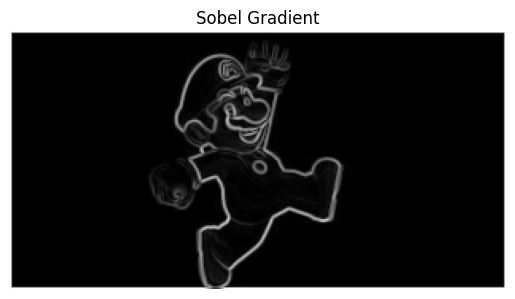

In [ ]:
sobel_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
sobel_y = np.array([[-1, -2, -1],[0,0,0],[1,2,1]])
sobel_grad_x = manual_convolution(blurred_img,sobel_x)
sobel_grad_y = manual_convolution(blurred_img,sobel_y)
sobel_magnitude = np.sqrt(sobel_grad_x**2 + sobel_grad_y**2)
sobel_direction = np.arctan2(sobel_grad_y, sobel_grad_x) * (180.0 / np.pi)
sobel_direction[sobel_direction < 0] += 180
plot.imshow(sobel_magnitude, cmap='gray')
plot.title('Sobel Gradient')
plot.axis('off')
plot.show()


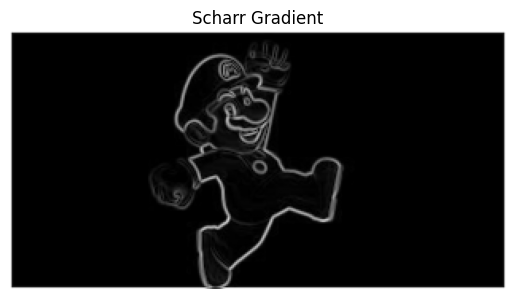

In [ ]:
scharr_x = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]])
scharr_y = np.array([[-3, -10, -3], [0, 0, 0], [3, 10, 3]])
scharr_grad_x = manual_convolution(blurred_img, scharr_x)
scharr_grad_y = manual_convolution(blurred_img, scharr_y)
scharr_magnitude = np.sqrt(scharr_grad_x**2 + scharr_grad_y**2)
scharr_direction = np.arctan2(scharr_grad_y, scharr_grad_x) * (180.0 / np.pi)
scharr_direction[scharr_direction < 0] += 180
plot.imshow(scharr_magnitude, cmap='gray')
plot.title('Scharr Gradient')
plot.axis('off')
plot.show()

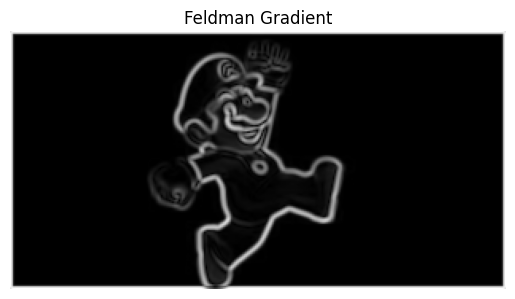

In [ ]:
feldman_x = np.array([[-2, -1, 0, 1, 2],
                      [-4, -2, 0, 2, 4],
                      [-6, -3, 0, 3, 6],
                      [-4, -2, 0, 2, 4],
                      [-2, -1, 0, 1, 2]])
feldman_y = np.array([[-2, -4, -6, -4, -2],
                      [-1, -2, -3, -2, -1],
                      [0, 0, 0, 0, 0],
                      [1, 2, 3, 2, 1],
                      [2, 4, 6, 4, 2]])
feldman_grad_x = manual_convolution(blurred_img, feldman_x)
feldman_grad_y = manual_convolution(blurred_img, feldman_y)
feldman_magnitude = np.sqrt(feldman_grad_x**2 + feldman_grad_y**2)
feldman_direction = np.arctan2(feldman_grad_y, feldman_grad_x) * (180.0 / np.pi)
feldman_direction[feldman_direction < 0] += 180
plot.imshow(feldman_magnitude, cmap='gray')
plot.title('Feldman Gradient')
plot.axis('off')
plot.show()



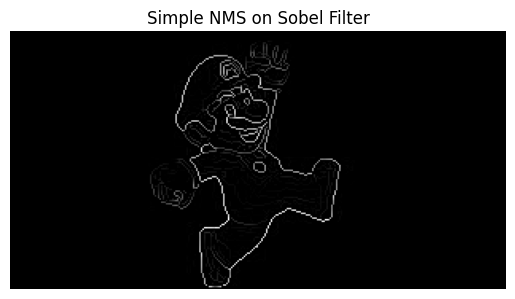

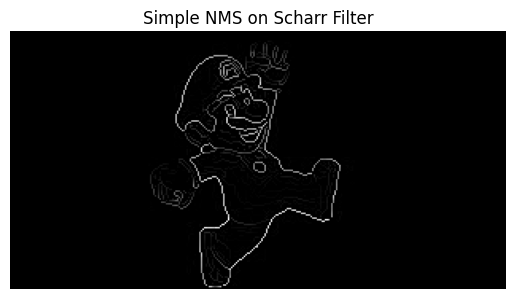

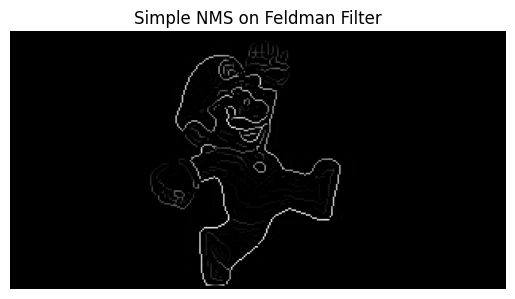

In [ ]:
# Implemented a simplified version of non-maximum suppression
def simple_nms(magnitude, direction):
    h, w = magnitude.shape
    output = np.zeros((h, w), dtype=np.float32)

    angle = direction % 180

    for i in range(1, h-1):
        for j in range(1, w-1):
            deg = angle[i, j]

            if (0 <= deg < 45) or (135 <= deg < 180):
                before = magnitude[i, j-1]
                after = magnitude[i, j+1]
            elif 45 <= deg < 135:
                before = magnitude[i-1, j]
                after = magnitude[i+1, j]
            else:
                before = 0
                after = 0

            if magnitude[i, j] >= before and magnitude[i, j] >= after:
                output[i, j] = magnitude[i, j]

    return output

nms_sobel_result = simple_nms(sobel_magnitude, sobel_direction)
plot.imshow(nms_sobel_result, cmap='gray')
plot.title("Simple NMS on Sobel Filter")
plot.axis('off')
plot.show()

nms_scharr_result = simple_nms(scharr_magnitude, scharr_direction)
plot.imshow(nms_scharr_result, cmap='gray')
plot.title("Simple NMS on Scharr Filter")
plot.axis('off')
plot.show()

nms_feldman_result = simple_nms(feldman_magnitude, feldman_direction)
plot.imshow(nms_feldman_result, cmap='gray')
plot.title("Simple NMS on Feldman Filter")
plot.axis('off')
plot.show()

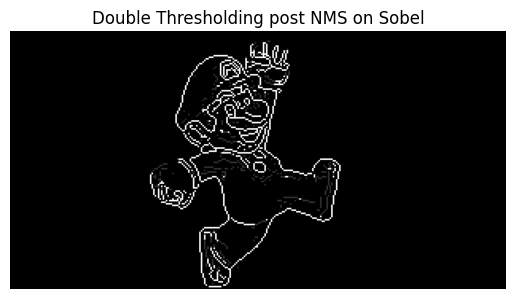

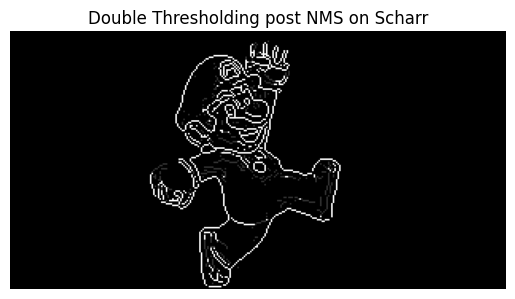

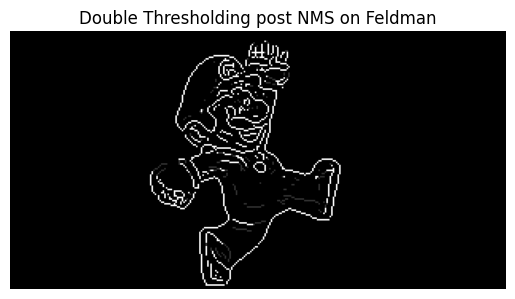

In [ ]:
def double_threshold(img, low_ratio=0.5, high_ratio=0.09):
    high_thresh = img.max() * high_ratio
    low_thresh = high_thresh * low_ratio

    strong = 255
    weak = 50

    result = np.zeros_like(img, dtype=np.uint8)

    strong_i, strong_j = np.where(img >= high_thresh)
    weak_i, weak_j = np.where((img >= low_thresh) & (img < high_thresh))

    result[strong_i, strong_j] = strong
    result[weak_i, weak_j] = weak

    return result

sobel_thresholded = double_threshold(nms_sobel_result)
plot.imshow(sobel_thresholded, cmap='gray')
plot.title("Double Thresholding post NMS on Sobel")
plot.axis('off')
plot.show()

scharr_thresholded = double_threshold(nms_scharr_result)
plot.imshow(scharr_thresholded, cmap='gray')
plot.title("Double Thresholding post NMS on Scharr")
plot.axis('off')
plot.show()


feldman_thresholded = double_threshold(nms_feldman_result)
plot.imshow(feldman_thresholded, cmap='gray')
plot.title("Double Thresholding post NMS on Feldman")
plot.axis('off')
plot.show()

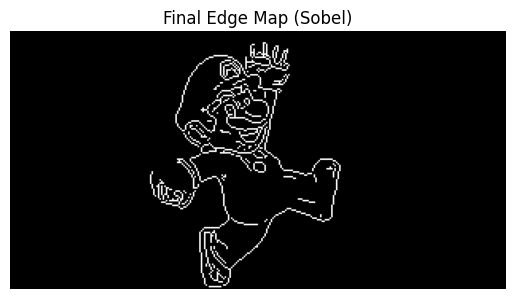

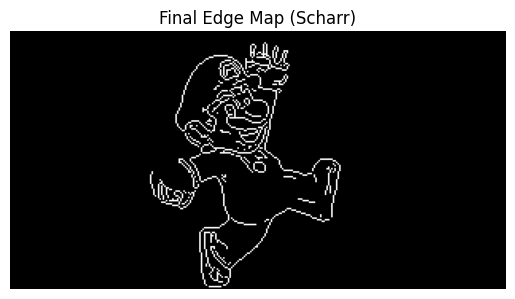

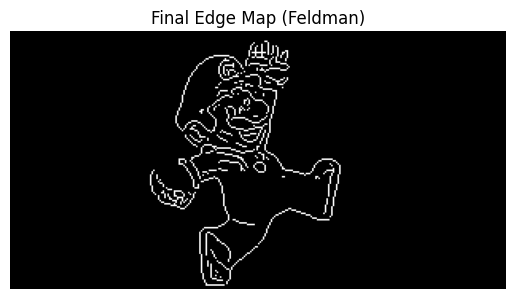

In [ ]:
def hysteresis(thresh_img, weak=50, strong=255):
    h, w = thresh_img.shape
    result = np.copy(thresh_img)

    for i in range(1, h-1):
        for j in range(1, w-1):
            if result[i, j] == weak:
                if (
                    result[i+1, j-1] == strong or result[i+1, j] == strong or result[i+1, j+1] == strong or
                    result[i, j-1] == strong or result[i, j+1] == strong or
                    result[i-1, j-1] == strong or result[i-1, j] == strong or result[i-1, j+1] == strong
                ):
                    result[i, j] = strong
                else:
                    result[i, j] = 0
    return result

final_edges = hysteresis(sobel_thresholded)
plot.imshow(final_edges, cmap='gray')
plot.title("Final Edge Map (Sobel)")
plot.axis('off')
plot.show()

final_edges = hysteresis(scharr_thresholded)
plot.imshow(final_edges, cmap='gray')
plot.title("Final Edge Map (Scharr)")
plot.axis('off')
plot.show()

final_edges = hysteresis(feldman_thresholded)
plot.imshow(final_edges, cmap='gray')
plot.title("Final Edge Map (Feldman)")
plot.axis('off')
plot.show()
